# CIFAR10 Classifier
## (Prototype Model Training)

This notebook has the purpuse of showing how to train a CNN using PyTorch, saving a routine that can be extended for future applications and to provide a way to check if PyTorch is able to use de GPUs correctly. With this goal in mind, we try to solve the problem of image classification in the CIFAR10 dataset, which consists of 60,000 32x32 colour images classified within 10 classes. The clases represent objects such as airplanes, automobiles, birds, cats, etc.

For us to be able to build any sort of deep learning model we need to call the following libraries.

In [16]:
# Display image
from matplotlib.pyplot import imshow
# General purposes
import numpy as np
import pandas as pd
# PyTorch stuff
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim
from torchvision.models import resnet18
from torchsummary import summary

## 1. Dataset

In the next cell, we define the set of transforms that will be applied to the images before passing to the network. 

In [17]:
custom_transforms = transforms.Compose([
    transforms.ToTensor()])

Now, we download the Fashion-MNIST data set

In [18]:
train_data = CIFAR10(root='./data', train=True, download=True, transform=custom_transforms)
valid_data = CIFAR10(root='./data', train=False, download=True, transform=custom_transforms)

Files already downloaded and verified
Files already downloaded and verified


We can create a list with the classes

In [19]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's see how do the images look like 

frog


&lt;matplotlib.image.AxesImage at 0x7ff45d167220&gt;

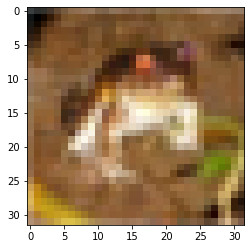

In [20]:
image, label = train_data[0]
print(classes[label])
imshow(image.permute(1, 2, 0))

cat


&lt;matplotlib.image.AxesImage at 0x7ff45d1f9ac0&gt;

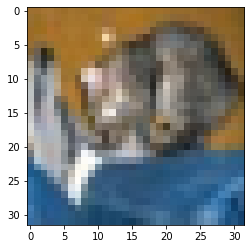

In [21]:
image, label = valid_data[0]
print(classes[label])
imshow(image.permute(1, 2, 0))

For being able to pass the data to the neural networks we need to use a dataloader object

In [22]:
train_dataloader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_data, batch_size=10, shuffle=True)

Before we star building the models, we define a funcion which will help us visualize a summary of the models

In [23]:
# Shows a summary of the network
def network_summary(network, input_size):
    summary(network, input_data = input_size)
    return None

## 2. Networks 

In this section we'll define the neural network we are going to work with. We'll use two networks, one built from scratch and an ResNet-18 based model, which we'll create using the predefined models provided by PyTorch

### 2.1 Model Fron Scratch

In [24]:
class custom_network(nn.Module):
    # Constructor
    def __init__(self):
        super(custom_network, self).__init__()
        # Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.AdaptiveAvgPool2d(output_size=(5,5))
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        
    # Forward Pass
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    # Prints a summary of the network 
    def summary(self, input_size):
        summary(self, input_data = input_size)
        return None

Let's instantiate an object of the custom_network class 

In [25]:
net_1 = custom_network()
net_1.summary(input_size=(3,28,28))

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 24, 24]           456
├─AvgPool2d: 1-2                         [-1, 6, 12, 12]           --
├─Conv2d: 1-3                            [-1, 16, 8, 8]            2,416
├─AdaptiveAvgPool2d: 1-4                 [-1, 16, 5, 5]            --
├─Linear: 1-5                            [-1, 84]                  33,684
├─Linear: 1-6                            [-1, 10]                  850
Total params: 37,406
Trainable params: 37,406
Non-trainable params: 0
Total mult-adds (M): 0.45
------------------------------------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.14
Estimated Total Size (MB): 0.19
------------------------------------------------------------------------------------------


## 2.2 ResNet18 Based Model

Now we create a network that is based on ResNet18

In [26]:
def resnet_based_model(num_classes = 1000, pretrained = False):
    if num_classes == 1000:
        network = resnet18(pretrained = pretrained, num_classes = num_classes)
    else:
        network = resnet18(pretrained = pretrained)
        fc_input_size = network.fc.in_features
        network.fc = nn.Linear(in_features = fc_input_size, out_features = num_classes, bias = True)

    return network

Given that resnet18 is a function, not a class, we cannot create a son class that adds the summary functionality. However, we can display a summary of the model as follows

In [27]:
resnet18_net = resnet_based_model(num_classes=10, pretrained=True)
network_summary(resnet18_net, input_size=(3,32,32))

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 16, 16]          128
├─ReLU: 1-3                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [-1, 64, 8, 8]            --
├─Sequential: 1-5                        [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-1                   [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-1                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-4                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-6                    [-1, 64, 

## 3. Train the Models

## 3.1. Custom Network

### 3.1.1 Loss Function and Optimizer

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_1.parameters(), lr=0.001, momentum=0.9)

### 3.1.2 Training 

In [29]:
def predict_labels(output):
    _, pred_labels = torch.max(output, dim = 1)
    return pred_labels

def correct_predictions(output, labels):
    pred_labels = predict_labels(output)
    corr_pred = torch.sum(pred_labels == labels).item()
    return corr_pred

def print_training_progress(epoch, epochs, batch_num):
    print('Epoch: ' + str(epoch + 1) + ', Batch: ' + str(batch_num + 1) + '/' + str(epochs))
    return None

def print_performance(metrics):
    epoch = metrics['epoch']
    train_loss = metrics['train_loss']
    train_acc = metrics['train_acc']
    valid_loss = metrics['valid_loss']
    valid_acc = metrics['valid_acc']
    print('Epoch: ' + str(epoch + 1) + ' || Train loss = ' + str(round(train_loss,2)) + ', Train Acc = ' + str(round(train_acc,2)) + ', Valid Loss = ' + str(round(valid_loss,2)) + ', Valid Acc = ' + str(round(valid_acc,2)))
    return None

In [30]:
epochs = 20
save_best_model = True
best_accuracy = - np.inf

metrics = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'])

# Training loop, loops over the dataset epochs times
for epoch in range(epochs):

    #TRAINING
    net_1.train()
    # Set the metrics to 0 for this epoch
    train_loss = 0
    train_acc = 0

    # Trains over the training set
    for batch_num, data in enumerate(train_dataloader):
        # Print progess 
        #print_training_progress(epoch, len(train_dataloader), batch_num)
        # Gets the data
        images, labels = data
        # training step
        optimizer.zero_grad()
        output = net_1(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        # Metrics
        train_loss = train_loss + loss.item()
        train_acc = train_acc + correct_predictions(output, labels)
        
    # Calculates the metrics for the training set
    total_images_train = len(train_dataloader)
    train_loss = train_loss / total_images_train
    train_acc = (train_acc / total_images_train) * 100

    # VALIDATION
    net_1.eval()
    valid_loss = 0
    valid_acc = 0

    for data in valid_dataloader:
        # Gets the data
        images, labels = data
        # Evaluates
        output = net_1(images)
        # Metrics
        loss = loss_fn(output, labels)
        valid_loss = valid_loss + loss.item()
        valid_acc = valid_acc + correct_predictions(output, labels)

    # Calculates the metrics for the validation set
    total_images_val = len(valid_dataloader)
    valid_loss = valid_loss / total_images_val
    valid_acc = (valid_acc / total_images_val) * 100

    # Saves the metrics per epoch
    metrics_epoch = {'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc, 'valid_loss': valid_loss, 'valid_acc': valid_acc}
    # Stores the epoch's metrics
    metrics = metrics.append(metrics_epoch, ignore_index = True)
    # Saves the metrics history so far
    metrics.to_csv('metrics_history.csv', index = False)
    # Print the performance for the epoch
    print_performance(metrics_epoch)
    # Saves the model
    torch.save(net_1.state_dict, 'last_wiehgts.pt')
    # Saves the best model
    if save_best_model and valid_acc > best_accuracy:
        torch.save(net_1.state_dict(), 'best_weights.pt')
        best_accuracy = valid_acc     
    
print('Finished Training, Hurray!!! :D')

Epoch: 1 || Train loss = 1.94, Train Acc = 285.32, Valid Loss = 1.63, Valid Acc = 412.6
Epoch: 2 || Train loss = 1.58, Train Acc = 434.16, Valid Loss = 1.49, Valid Acc = 464.8
Epoch: 3 || Train loss = 1.46, Train Acc = 477.38, Valid Loss = 1.4, Valid Acc = 497.1
Epoch: 4 || Train loss = 1.38, Train Acc = 506.1, Valid Loss = 1.35, Valid Acc = 515.4
Epoch: 5 || Train loss = 1.32, Train Acc = 529.72, Valid Loss = 1.34, Valid Acc = 528.2
Epoch: 6 || Train loss = 1.27, Train Acc = 548.62, Valid Loss = 1.27, Valid Acc = 549.1
Epoch: 7 || Train loss = 1.22, Train Acc = 565.42, Valid Loss = 1.26, Valid Acc = 557.1
Epoch: 8 || Train loss = 1.18, Train Acc = 582.42, Valid Loss = 1.23, Valid Acc = 563.9
Epoch: 9 || Train loss = 1.15, Train Acc = 594.44, Valid Loss = 1.24, Valid Acc = 559.9
Epoch: 10 || Train loss = 1.12, Train Acc = 604.16, Valid Loss = 1.23, Valid Acc = 565.9
Epoch: 11 || Train loss = 1.09, Train Acc = 614.04, Valid Loss = 1.18, Valid Acc = 582.1
Epoch: 12 || Train loss = 1.06, 